### Pull MongoDB data


In [1]:
import os
import datetime as dt
import pandas as pd
import csv

In [2]:
# add the 'src' directory as one where we can import modules
import sys
import pathlib # __file__ isn't recognized in Jupyter, so we need this to get the root path
path = pathlib.Path.cwd()
PROJ_ROOT = path.parent 
src_dir = str(PROJ_ROOT / 'src')
PROJ_ROOT = str(PROJ_ROOT)
sys.path.append(src_dir)
# from data import make_dataset

In [3]:
from data import user_df_setup

interim_data_file_path = os.path.join(PROJ_ROOT,
                                 "data",
                                 "interim",
                                 "full_users_df.pkl")
# users_df = pd.read_pickle(interim_data_file_path)
raw_data_file_path = os.path.join(PROJ_ROOT,
                             "data",
                             "raw",
                             "users_df.pkl")
raw_users_df = pd.read_pickle(raw_data_file_path)

all_users_df = user_df_setup.user_df_setup(raw_data_file_path, interim_data_file_path)

users_df = all_users_df
# raw_users_df
# raw_users_df[['username', 'timeCreated']].sort_values('timeCreated', ascending = False).head(20)
all_users_df.sort_values('date_created', ascending = False).head(5)
# all_users_df.index
# all_users_df.head(20)

,date_created,refresh_time,userId,unrated_threshold,risky_threshold,supportive_threshold
username,,,,,,
davidt,2019-04-16,NaN,5cb60fc57aeafc0011cec7b2,0.0,1.0,3.0
pinky618,2019-03-20,NaN,5c92a052683da8001107a632,0.0,1.0,3.0
doyle coleman,2019-03-19,NaN,5c90fb30939ba200110ff237,0.0,1.0,3.0
driverseat,2019-03-19,NaN,5c90fa54939ba200110ff229,0.0,1.0,3.0
blonco,2019-03-19,NaN,5c90f9ea683da8001107a5af,0.0,1.0,3.0


In [4]:
current_users = all_users_df[all_users_df['date_created'] > (dt.date.today() - dt.timedelta(30))]
user_ids = all_users_df['userId'].tolist()
print(len(user_ids))
# user_ids

136


## Set Usernames of Interest

In [5]:
usernames = current_users.index
usernames = ['pinky618','+vinny', 'davidt']

### Force-pulling Contacts data from MongoDB

In [6]:
from data import database_query

raw_data_path = os.path.join(PROJ_ROOT,
                             "data",
                             "raw")
# current_users_df = all_users_df[all_users_df['date_created'] > (dt.date.today() - dt.timedelta(30))]
current_users_df = all_users_df[all_users_df.index.isin(usernames)]
user_ids = current_users_df['userId'].tolist()
database_query.make_raw_contacts_df(database_query.mongo_connect(),
                                   raw_data_path,
                                   user_ids)

In [7]:
current_users_df

,date_created,refresh_time,userId,unrated_threshold,risky_threshold,supportive_threshold
username,,,,,,
+vinny,2018-11-14,NaN,5bec3a6b1dc2970010696def,0.0,1.0,3.0
pinky618,2019-03-20,NaN,5c92a052683da8001107a632,0.0,1.0,3.0
davidt,2019-04-16,NaN,5cb60fc57aeafc0011cec7b2,0.0,1.0,3.0


### Force-creating Contacts interim data

In [8]:
from data import contacts_df_setup
from data import user_df_setup

interim_data_path = os.path.join(PROJ_ROOT,
                                 "data",
                                 "interim")
contacts_dict = {}

for username in usernames: 
    interim_contact_data_file_path = os.path.join(interim_data_path, 'contacts_df_' + username + '.pkl')
    if os.path.isfile(interim_contact_data_file_path):
        contacts_df = pd.read_pickle(interim_contact_data_file_path)
    else:
        current_users_df = user_df_setup.user_df_setup(os.path.join(raw_data_path, 'users_df.pkl'),
                                               os.path.join(interim_data_path, 'users_df.pkl'))
        contacts_df = contacts_df_setup.contacts_df_setup(username,
                                                          current_users_df,
                                                          raw_data_path,
                                                          interim_data_path)
    contacts_dict[username] = contacts_df

In [9]:
contacts_dict['+vinny'].head(10)

,score,relationship
_id,,
5bec3be00eb5fd0010495e3c,-1.000000,family
5bec3d440eb5fd0010495e54,-1.000000,risky
5bec3d551dc2970010696e09,-1.000000,risky
5bec3d570eb5fd0010495e55,4.274688,friend
5bec47481dc2970010696e19,-1.000000,none
5bec495c0eb5fd0010495e5c,-1.000000,none
5bec49730eb5fd0010495e5d,1.729452,other
5bec4aa00eb5fd0010495e5e,-1.000000,family
5bec4aae0eb5fd0010495e5f,-1.000000,risky


In [10]:
for count, e in enumerate(usernames):  
    unrated_threshold = users_df.loc[e, 'unrated_threshold']
    risky_threshold = users_df.loc[e, 'risky_threshold']
    supportive_threshold = users_df.loc[e, 'supportive_threshold']
    
    contacts_df = contacts_dict[e].sort_values('score', ascending = False)
    contacts_dict[e]['risk_assignment'] = None
    
    contacts_dict[e].loc[((contacts_df['score'] < unrated_threshold)
                    & (contacts_df['relationship'] != 'risky')),'risk_assignment'] = 'unrated'
#     unrated = contacts_df['score'][(contacts_df['score'] < unrated_threshold)
#                                   & (contacts_df['relationship'] != 'risky')]
#     print(contacts_dict[e].head())
    contacts_dict[e].loc[((contacts_df['relationship'] == 'risky')
                        | ((contacts_df['score'] >= unrated_threshold)
                            & (contacts_df['score'] <= risky_threshold))), 'risk_assignment'] = 'risky'
#     risky = contacts_df['score'][(contacts_df['relationship'] == 'risky')
#                                 | ((contacts_df['score'] >= unrated_threshold)
#                                 & (contacts_df['score'] <= risky_threshold))]
    
    contacts_dict[e].loc[((contacts_df['score'] > risky_threshold)
                        & (contacts_df['score'] < supportive_threshold)
                        & (contacts_df['relationship'] != 'risky')), 'risk_assignment'] ='neutral'
#     neutral = contacts_df['score'][(contacts_df['score'] > risky_threshold)
#                                 & (contacts_df['score'] < supportive_threshold)]
    
    contacts_dict[e].loc[((contacts_df['score'] >= supportive_threshold)
                        & (contacts_df['relationship'] != 'risky')), 'risk_assignment'] ='supportive'
#     supportive = contacts_df['score'][(contacts_df['score'] >= supportive_threshold)]
# contacts_dict['+vinny'].head(10)

In [11]:
import matplotlib.pyplot as plt

f, axarr = plt.subplots(len(usernames),figsize=(10,4*len(usernames)), sharex = True, sharey = True, squeeze=False)
plt.tight_layout()

for count, e in enumerate(usernames):  
    unrated_threshold = users_df.loc[e, 'unrated_threshold']
    risky_threshold = users_df.loc[e, 'risky_threshold']
    supportive_threshold = users_df.loc[e, 'supportive_threshold']
    
    contacts_df = contacts_dict[e].sort_values('score', ascending = False)

    unrated = contacts_df['score'][(contacts_df['risk_assignment'] == 'unrated')]
    risky = contacts_df['score'][(contacts_df['risk_assignment'] == 'risky')]
    neutral = contacts_df['score'][(contacts_df['risk_assignment'] == 'neutral')]
    supportive = contacts_df['score'][(contacts_df['risk_assignment'] == 'supportive')]
    
    axarr[count, 0].bar(supportive.index, supportive, 0.7, color = '#00cc00')
    axarr[count, 0].bar(neutral.index, neutral, 0.7, color = 'b')
    axarr[count, 0].bar(risky.index, risky, 0.7, color = '#ff6600')
#     axarr[count, 0].bar(unrated.index, unrated, 0.7, color = '#C0C0C0')
    axarr[count, 0].set_title(e + ' - rated: ' + str(len(contacts_df) - len(unrated)) + ' unrated: ' + str(len(unrated)))
    
    # unrelated, pulling the counts
#     current_users_df.loc[e, 'unrated_contacts'] = len(unrated)
#     current_users_df.loc[e, 'risky_contacts'] = len(risky)
#     current_users_df.loc[e, 'neutral_contacts'] = len(neutral)
#     current_users_df.loc[e, 'supportive_contacts'] = len(supportive)
#     current_users_df.loc[e, 'rated_contacts'] = len(contacts_df) - current_users_df.loc[e, 'unrated_contacts']
# current_users_df
# plt.show()

,date_created,refresh_time,userId,unrated_threshold,risky_threshold,supportive_threshold
username,,,,,,
+vinny,2018-11-14,NaN,5bec3a6b1dc2970010696def,0.0,1.0,3.0
pinky618,2019-03-20,NaN,5c92a052683da8001107a632,0.0,1.0,3.0
davidt,2019-04-16,NaN,5cb60fc57aeafc0011cec7b2,0.0,1.0,3.0


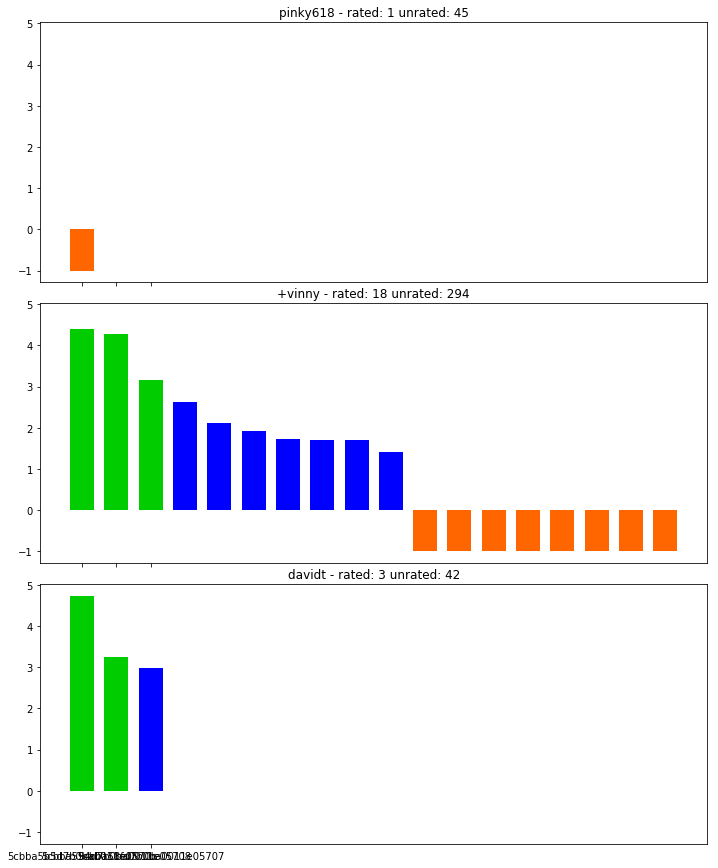

In [12]:
import matplotlib.pyplot as plt

f, axarr = plt.subplots(len(usernames),figsize=(10,4*len(usernames)), sharex = True, sharey = True, squeeze=False)
plt.tight_layout()

for count, e in enumerate(usernames):  
    unrated_threshold = users_df.loc[e, 'unrated_threshold']
    risky_threshold = users_df.loc[e, 'risky_threshold']
    supportive_threshold = users_df.loc[e, 'supportive_threshold']
    
    contacts_df = contacts_dict[e].sort_values('score', ascending = False)
    unrated = contacts_df['score'][(contacts_df['score'] < unrated_threshold)
                                  & (contacts_df['relationship'] != 'risky')]
    risky = contacts_df['score'][(contacts_df['relationship'] == 'risky')
                                | ((contacts_df['score'] >= unrated_threshold)
                                & (contacts_df['score'] <= risky_threshold))]
    neutral = contacts_df['score'][(contacts_df['score'] > risky_threshold)
                                & (contacts_df['score'] < supportive_threshold)]
    supportive = contacts_df['score'][(contacts_df['score'] >= supportive_threshold)]
    
    axarr[count, 0].bar(supportive.index, supportive, 0.7, color = '#00cc00')
    axarr[count, 0].bar(neutral.index, neutral, 0.7, color = 'b')
    axarr[count, 0].bar(risky.index, risky, 0.7, color = '#ff6600')
#     axarr[count, 0].bar(unrated.index, unrated, 0.7, color = '#C0C0C0')
    axarr[count, 0].set_title(e + ' - rated: ' + str(len(contacts_df) - len(unrated)) + ' unrated: ' + str(len(unrated)))
    
current_users_df.head()
# plt.show()

c:\users\vinny\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\vinny\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Text(0.5, 1.0, 'Rated Contacts by Type')

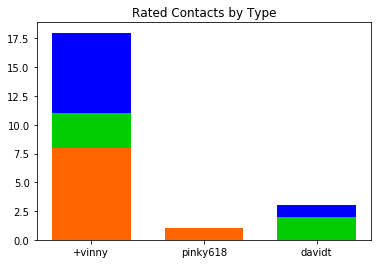

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# f, axarr = plt.subplots(len(usernames),figsize=(10,4*len(usernames)), sharex = True, sharey = True, squeeze=False)
# plt.tight_layout()
fig = plt.figure()
ax = fig.add_subplot(111)

for count, e in enumerate(usernames):  
    contacts_df = contacts_dict[e].sort_values('score', ascending = False)

    current_users_df.loc[e, 'unrated_contacts'] = len(contacts_df[contacts_df['risk_assignment'] == 'unrated'])
    current_users_df.loc[e, 'risky_contacts'] = len(contacts_df[contacts_df['risk_assignment'] == 'risky'])
    current_users_df.loc[e, 'neutral_contacts'] = len(contacts_df[contacts_df['risk_assignment'] == 'neutral'])
    current_users_df.loc[e, 'supportive_contacts'] = len(contacts_df[contacts_df['risk_assignment'] == 'supportive'])
    current_users_df.loc[e, 'rated_contacts'] = len(contacts_df) - current_users_df.loc[e, 'unrated_contacts']

# for count, e in enumerate(usernames):     
ax.bar(current_users_df.index, current_users_df['risky_contacts'], 0.7, color = '#ff6600')
ax.bar(current_users_df.index, current_users_df['supportive_contacts'], 0.7, color = '#00cc00', bottom=current_users_df['risky_contacts'])
ax.bar(current_users_df.index, current_users_df['neutral_contacts'], 0.7, color = 'b', bottom=np.array(current_users_df['supportive_contacts'])+np.array(current_users_df['risky_contacts'])) 
# ax.bar(current_users_df.index, current_users_df['unrated_contacts'], 0.7, color = '#C0C0C0', bottom=current_users_df['neutral_contacts'])
#     axarr[count, 0].bar(unrated.index, unrated, 0.7, color = '#C0C0C0')
ax.set_title('Rated Contacts by Type')

# plt.show()

Text(0.5, 1.0, 'Contacts by Relationship')

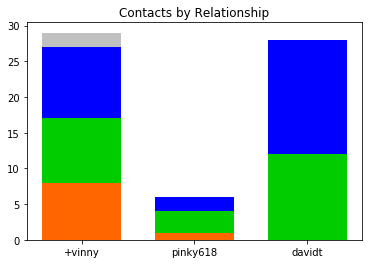

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# f, axarr = plt.subplots(len(usernames),figsize=(10,4*len(usernames)), sharex = True, sharey = True, squeeze=False)
# plt.tight_layout()
fig = plt.figure()
ax = fig.add_subplot(111)

for count, e in enumerate(usernames):  
    contacts_df = contacts_dict[e].sort_values('score', ascending = False)

    current_users_df.loc[e, 'family_contacts'] = len(contacts_df[(contacts_df['relationship'] == 'family')
                                                                & (contacts_df['risk_assignment'] != 'risky')])
    current_users_df.loc[e, 'friend_contacts'] = len(contacts_df[(contacts_df['relationship'] == 'friend')
                                                                & (contacts_df['risk_assignment'] != 'risky')])
    current_users_df.loc[e, 'risky_contacts'] = len(contacts_df[(contacts_df['relationship'] == 'risky')
                                                                | (contacts_df['risk_assignment'] == 'risky')])
    current_users_df.loc[e, 'other_contacts'] = len(contacts_df[(contacts_df['relationship'] == 'other')
                                                                & (contacts_df['risk_assignment'] != 'risky')])
#     current_users_df.loc[e, 'rated_contacts'] = len(contacts_df) - current_users_df.loc[e, 'unrated_contacts']

# for count, e in enumerate(usernames):     
ax.bar(current_users_df.index, current_users_df['risky_contacts'], 0.7, color = '#ff6600')
ax.bar(current_users_df.index, current_users_df['family_contacts'], 0.7, color = '#00cc00', bottom=current_users_df['risky_contacts'])
ax.bar(current_users_df.index, current_users_df['friend_contacts'], 0.7, color = 'b', bottom=np.array(current_users_df['family_contacts'])+np.array(current_users_df['risky_contacts'])) 
ax.bar(current_users_df.index, current_users_df['other_contacts'], 0.7, color = '#C0C0C0', bottom=np.array(current_users_df['friend_contacts'])+np.array(current_users_df['family_contacts'])+np.array(current_users_df['risky_contacts'])) 
# ax.bar(current_users_df.index, current_users_df['unrated_contacts'], 0.7, color = '#C0C0C0', bottom=current_users_df['neutral_contacts'])
#     axarr[count, 0].bar(unrated.index, unrated, 0.7, color = '#C0C0C0')
ax.set_title('Contacts by Relationship')

# plt.show()

### Force Creating Comm Data

In [15]:
from data import comm_df_analyses

interim_data_path = os.path.join(PROJ_ROOT,
                                 "data",
                                 "interim")
comm_dict = {}
missing_comm_users = []
for username in usernames: 
#     if username not in current_users_df.index:
#         print(username + ' not in current_users_df')
#         missing_comm_users.append(username)
#         continue
        
#     interim_comm_data_file_path = os.path.join(interim_data_path, 'day_comm_log_df_' + username + '.pkl')
#     if os.path.isfile(interim_comm_data_file_path):
#         daily_comm_df = pd.read_pickle(interim_comm_data_file_path)
#         daily_comm_dict[username] = daily_comm_df
        
    interim_comm_data_file_path = os.path.join(interim_data_path, 'comm_log_df_' + username + '.pkl')
    if os.path.isfile(interim_comm_data_file_path):
        comm_df = pd.read_pickle(interim_comm_data_file_path)
    else:
        comm_df = comm_df_analyses.comm_df_setup(username,
                                              current_users_df,
                                              contacts_dict[username],
                                              raw_data_path,
                                              interim_data_path)
    comm_dict[username] = comm_df
# print(missing_comm_users)
# usernames = list(set(usernames) - set(missing_users))
# print(comm_dict['+vinny'].head())

#### Pulling daily comm by contact

In [16]:
day_contact_comm_dict = {}
for username in usernames: 
    day_contact_comm_df = comm_df_analyses.contact_time_bucket_comm(username,
                                                               users_df,
                                                               contacts_dict[username],
                                                               comm_dict[username],
                                                               interim_data_path,
                                                               'day')
    day_contact_comm_dict[username] = day_contact_comm_df
print(str(len(day_contact_comm_dict['+vinny'].columns)) + ' # of contacts')
day_contact_comm_dict['+vinny'].head()

937 # of contacts


_id,5bec3be00eb5fd0010495e3c,5bec3d440eb5fd0010495e54,5bec3d551dc2970010696e09,5bec3d570eb5fd0010495e55,5bec47481dc2970010696e19,5bec495c0eb5fd0010495e5c,5bec49730eb5fd0010495e5d,5bec4aa00eb5fd0010495e5e,5bec4aae0eb5fd0010495e5f,5bec4ab60eb5fd0010495e60,...,outbound_5cb0c42c2a394d0011d7e26f,inbound_5cb0ec09a47f150011c4444c,outbound_5cb0ec09a47f150011c4444c,inbound_5cb0f249a47f150011c4444e,outbound_5cb0f249a47f150011c4444e,inbound_5cb4922da47f150011c4446c,outbound_5cb4922da47f150011c4446c,inbound_5cb4e7fed7b0ba0011e0568a,outbound_5cb4e7fed7b0ba0011e0568a,total_comm
2018-11-14,13.0,7.0,0.0,0.0,9.0,2.0,3.0,3.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.0
2018-11-15,15.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.0
2018-11-16,9.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0
2018-11-17,0.0,0.0,0.0,5.0,12.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,160.0
2018-11-18,5.0,9.0,0.0,0.0,6.0,0.0,9.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.0


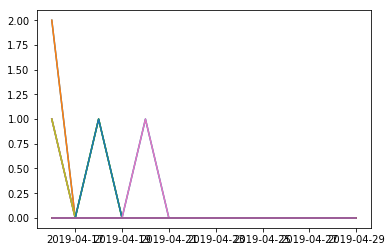

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(day_contact_comm_dict['davidt'].drop('total_comm', axis=1))


In [18]:
# current_users[['date_created', 'unrated_contacts', 'risky_contacts', 'neutral_contacts', 'supportive_contacts', 'rated_contacts']]
# current_users

In [19]:
# import numpy as np

# for username in usernames: 
#     if username in notification_dict.keys():
#         notifications_df = notification_dict[username]
#         current_users.loc[username, 'notifications'] = len(notifications_df.index)
#     else:
#         current_users.loc[username, 'notifications'] = 0

### SQL Analyses

In [20]:
from data import firebase_sql_queries

client = firebase_sql_queries.init_sql_connection()

In [63]:
reviver_events_dict = {}
for username in usernames:
    print(username)
    if username == 'pinky618':
        sql_username = 'Pinky618 '
    elif username == 'davidt':
        sql_username == 'DavidT'
    else:
        sql_username = username

    reviver_events = firebase_sql_queries.get_reviver_events(client, sql_username)
    reviver_events.index = pd.to_datetime(reviver_events['timestamp'], unit="us") - dt.timedelta(hours=4)
    reviver_events = reviver_events.drop(columns='timestamp')
    
    reviver_events_dict[username] = reviver_events
reviver_events_dict['+vinny'].head(15)

pinky618
+vinny
davidt


,event
timestamp,
2019-04-22 15:16:48.366062,reviver_scimitar_already_running
2019-04-22 15:16:47.564059,reviver_scimitar_already_running
2019-04-22 11:42:19.527422,reviver_scimitar_already_running
2019-04-22 11:42:18.591421,reviver_scimitar_already_running
2019-04-22 10:57:41.395039,reviver_scimitar_already_running
2019-04-22 10:56:57.338036,reviver_scimitar_already_running
2019-04-22 10:48:20.442033,reviver_scimitar_already_running
2019-04-22 10:48:18.077032,reviver_scimitar_already_running
2019-04-22 08:39:15.139265,reviver_scimitar_already_running


#### time bucketing reviver events

In [65]:
# def time_bucket_comm(username, users_df, comm_df, interim_data_path, period):
daily_activity_dict = {}
for username in usernames:
    print(username)
    today = dt.date.today()
    reviver_events = reviver_events_dict[username]
    date_created = all_users_df.loc[username, 'date_created']
    date_indices = pd.date_range(date_created, today + dt.timedelta(7), freq='D')

    activity_columns = ['reviver_scimitar_already_running', 'reviver_scimitar_starting']
    daily_activity_df = pd.DataFrame(np.nan, index=date_indices, columns=activity_columns)

    for j in activity_columns:
        data = reviver_events[reviver_events['event'] == j]
        col_name = j
        if len(data) > 0:  # not sure if this is necessary
            temp = data.groupby(pd.cut(data.index, daily_activity_df.index, right=False)).agg({'event': pd.Series.count})
            temp.columns = [col_name]
            temp = temp.reset_index()
            temp.index = temp['index'].apply(lambda x: x.left)
            daily_activity_df[col_name] = temp[col_name]
    daily_activity_df = daily_activity_df.fillna(0)
    daily_activity_dict[username] = daily_activity_df

daily_activity_dict['+vinny'].head(15)

pinky618
+vinny
davidt


,reviver_scimitar_already_running,reviver_scimitar_starting
2018-11-14,46.0,0.0
2018-11-15,50.0,0.0
2018-11-16,9.0,0.0
2018-11-17,91.0,0.0
2018-11-18,57.0,0.0
2018-11-19,45.0,0.0
2018-11-20,32.0,1.0
2018-11-21,118.0,0.0
2018-11-22,179.0,1.0
2018-11-23,58.0,1.0


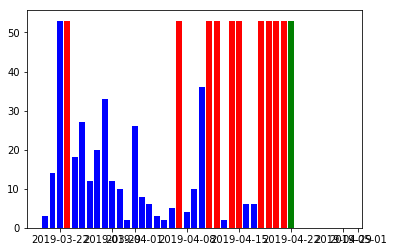

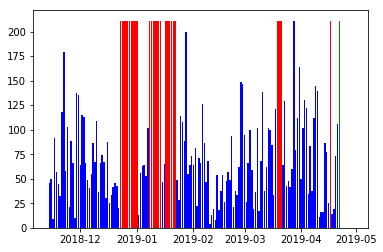

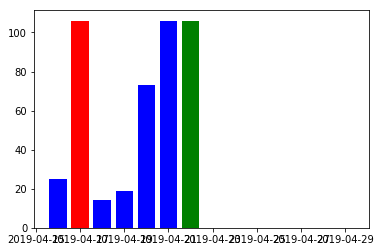

In [71]:
for count, username in enumerate(usernames):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    activity_columns = ['reviver_scimitar_already_running', 'reviver_scimitar_starting']
    data = daily_activity_dict[username][activity_columns[0]]
    
    today = dt.date.today()
    zero_data = data[data == 0]
    zero_data = zero_data[:today] + max(data)
    
    ax.bar(data.index, data, color='b')
    ax.bar(zero_data.index, zero_data, color='r')
    ax.bar(today,max(data), color='g')

plt.show()